# Pairwise causal discovery 

### Life expectancy vs Health expenditure

Goals: 
- analyze life expectancy in relation to health expenditure
- evaluate pairwise methods from causal discovery toolbox

Data Sources:
- Life expectancy: OurWorldInData, https://ourworldindata.org/grapher/life-expectancy?time=..&country=~OWID_WRL
- Health expenditure: WHO's Global Health Expenditure Database (GHED), http://apps.who.int/nha/database/Home/IndicatorsDownload/en
  
Libraries
- causal inference: `cdt`
- visualization: `matplotlib`, `seaborn`
- other libraries: `pandas`, `numpy`

### Step 1: Load and prepare data
#### 1.1.- Load data from `life-expectancy.csv`

In [1]:
FILENAME="data/life-expectancy.csv"
import pandas as pd
df_y = pd.read_csv(FILENAME)
df_y

,Entity,Code,Year,Life expectancy (years)
0,Afghanistan,AFG,1950,27.638
1,Afghanistan,AFG,1951,27.878
2,Afghanistan,AFG,1952,28.361
3,Afghanistan,AFG,1953,28.852
4,Afghanistan,AFG,1954,29.350
...,...,...,...,...
19023,Zimbabwe,ZWE,2015,59.534
19024,Zimbabwe,ZWE,2016,60.294
19025,Zimbabwe,ZWE,2017,60.812
19026,Zimbabwe,ZWE,2018,61.195


#### 1.2.- Load data from `health-expenditure.csv`

In [2]:
df_x = pd.read_csv('data/health_expenditure.csv', sep='|')
df_x

,Country Name,Country Code,Indicator Code,Year,Value
0,Antigua and Barbuda,ATG,sha11.HF,2000.0,444.939432
1,Antigua and Barbuda,ATG,sha11.HF,2001.0,497.096598
2,Antigua and Barbuda,ATG,sha11.HF,2002.0,512.317693
3,Antigua and Barbuda,ATG,sha11.HF,2003.0,569.649036
4,Antigua and Barbuda,ATG,sha11.HF,2004.0,547.871067
...,...,...,...,...,...
96522,Malawi,MWI,sha11.DIS.2.1_ext,2015.0,0.165924
96523,Malawi,MWI,sha11.DIS.2.1_ext,2016.0,0.144373
96524,Cambodia,KHM,sha11.DIS.2.1_ext,2015.0,0.978661
96525,Cambodia,KHM,sha11.DIS.2.1_ext,2016.0,1.179586


#### 1.3.- Clean NaN, adapt columns and merge into a single dataframe

In [3]:
# skip rows with (how=any) null values
df_x = df_x.dropna()
df_x.columns = ['Entity', 'Code', 'Indicator Code','Year', 'Health expenditure']
df_x = df_x.astype({'Year':'int64'})
df_x = df_x[df_x["Indicator Code"] == 'sha11.HF']
df_x.columns = ['Entity', 'Code', 'Indicator Code','Year', 'Health expenditure']
df_xy = df_x.merge(df_y)
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 3049
Data columns (total 6 columns):
Entity                     3050 non-null object
Code                       3050 non-null object
Indicator Code             3050 non-null object
Year                       3050 non-null int64
Health expenditure         3050 non-null float64
Life expectancy (years)    3050 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 166.8+ KB


### Step 2: Explore the data
#### 2.1.- Visualization

Histograms in diagonal. Scatterplot off diagonal

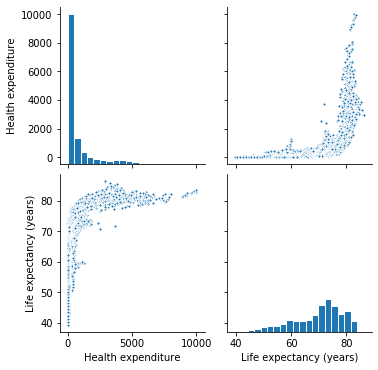

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_xy, vars=["Health expenditure", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

According to the charts, it seems that health expenditure is associated with increase in life expectancy. Though it seems the relation is not linear. So let's assume life expectancy is associated with increase in logarithm of health expenditure. And compare correlations

#### 2.2.- Correlations. Linear vs log-transformed


In [5]:
import numpy as np
corr = np.corrcoef(df_xy['Life expectancy (years)'], df_xy['Health expenditure'])
print(corr)

[[1.         0.57565989]
 [0.57565989 1.        ]]


In [6]:
corr = np.corrcoef(df_xy['Life expectancy (years)'], np.log(df_xy['Health expenditure']))
print(corr)

[[1.         0.80981449]
 [0.80981449 1.        ]]


Our assumption make sense. Let's add to `df_xy` the new variable `health_expenditure_log` with the logarithmic transformation of Health expenditure. And visualize again histograms and relationships between variables

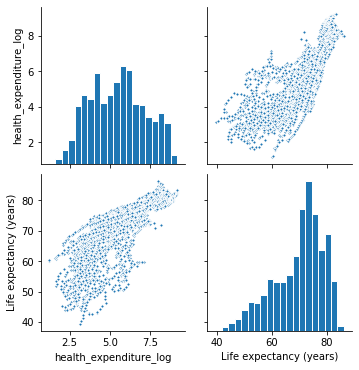

In [7]:
df_xy['health_expenditure_log'] = np.log(df_xy['Health expenditure'])
g = sns.PairGrid(df_xy, vars=["health_expenditure_log", "Life expectancy (years)"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

### Step 3: Pairwise causal discovery

#### 3.1.- Generate and plot undirected graph

- Model: `Glaso` (as `HSICLasso` gets `argmax of an empty sequence` error)
- Data: subset of 3 columns: `health_expenditure`, `health_expenditure_log` and `life_expectancy`

In [8]:
df = df_xy.loc[:,['Health expenditure', 'Life expectancy (years)', 'health_expenditure_log']]
df.columns = ['health_expenditure', 'life_expectancy', 'health_expenditure_log']
df.head()

,health_expenditure,life_expectancy,health_expenditure_log
0,444.939432,73.940,6.097938
1,497.096598,74.171,6.208784
2,512.317693,74.395,6.238945
3,569.649036,74.613,6.345020
4,547.871067,74.821,6.306040


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


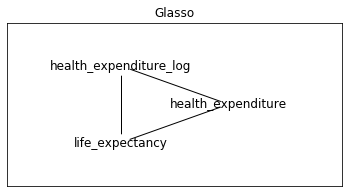

In [9]:
from cdt.independence.graph import HSICLasso,Glasso,DecisionTreeRegression

#obj = HSICLasso()
obj = Glasso()
ugraph = obj.predict(df)

import networkx as nx
import matplotlib.pyplot as plt
graph = ugraph

# Sort alphabetically, to keep same circular layout
sorted_graph = nx.Graph()
sorted_graph.add_edges_from(sorted(graph.edges()))
pos = nx.drawing.layout.circular_layout(sorted_graph)

plt.figure(0,figsize=(6,3)) 
nx.draw_networkx(sorted_graph,pos, node_color='#ffffff')
plt.title("Glasso")
plt.margins(1,0.5)
plt.show()

#### 3.2.- Plot directed graph

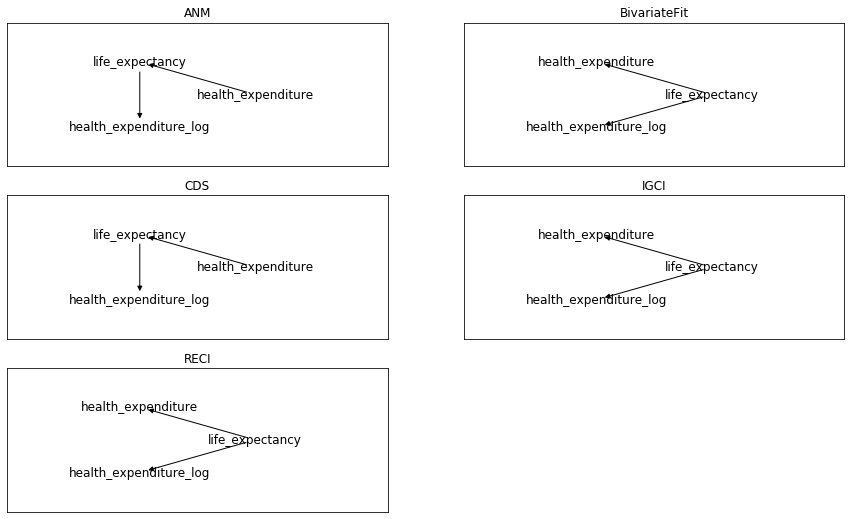

In [10]:
from cdt.causality.pairwise import *
def test_pairwise_model(mymodel,mycount):
    obj = mymodel()
    graph = obj.orient_graph(df, nx.DiGraph(ugraph))
    sorted_graph = nx.DiGraph()
    sorted_graph.add_edges_from(sorted(graph.edges()))
    pos = nx.drawing.layout.circular_layout(sorted_graph)

    #
    plt.subplot(3,2,mycount)
    nx.draw_networkx(sorted_graph,pos,node_color='#ffffff')
    plt.title(mymodel.__name__)
    plt.margins(1,0.5)
      
plt.figure(0,figsize=(15,9))

mycount = 1
for mymodel in [ANM,BivariateFit, CDS, IGCI, RECI]:
   
    test_pairwise_model(mymodel, mycount)
    mycount+=1
plt.show()